In [2]:
import importlib
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(str(Path("__file__").resolve().parent.parent))

from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (20, 12)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
LOG_FILE_PATH = "../../dataset/sample-trials/4_1_51.txt"
GIS_BASE_PATH = "../../dataset/gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [4]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, blescans_df = pdr.convert_to_dataframes(data)

In [5]:
from sub import pdr

importlib.reload(pdr)

map_dict = pdr.load_floor_maps(FLOOR_NAMES, GIS_BASE_PATH)
edit_map_dict = pdr.load_floor_maps(FLOOR_NAMES, GIS_BASE_PATH, "_edited")
floor_name = ground_truth_df.floor_name[0]

dx = 0.01
dy = 0.01

In [6]:
from scipy.signal import find_peaks

acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

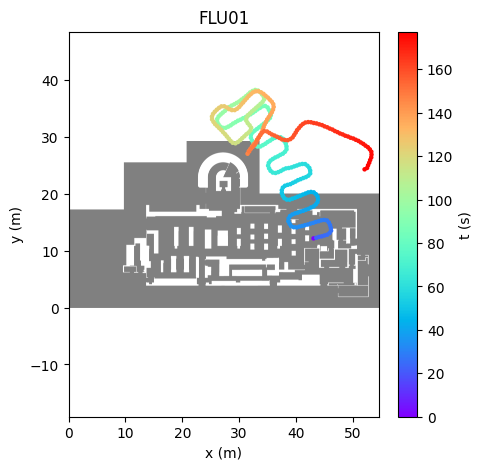

In [7]:
from sub import pdr, utils

importlib.reload(utils)
importlib.reload(pdr)

cumulative_displacement_angle, trajectory_df = pdr.estimate_trajectory(
    acc_df,
    gyro_df,
    ground_truth_first_point={
        "x": ground_truth_df.x[0],
        "y": ground_truth_df.y[0],
    },
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    trajectory_df,
)

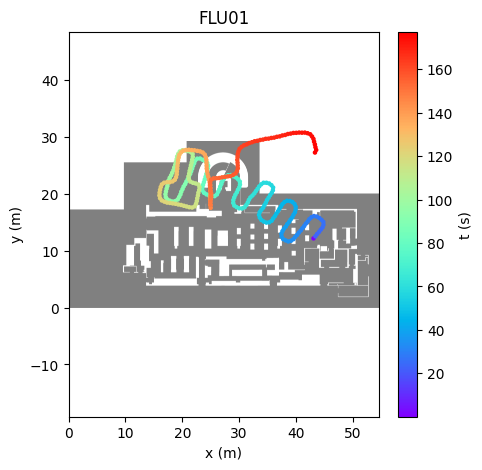

In [8]:
from sub import utils

importlib.reload(utils)

initial_direction = utils.extract_rotation(
    [
        ground_truth_df.q0[0],
        ground_truth_df.q1[0],
        ground_truth_df.q2[0],
        ground_truth_df.q3[0],
    ],
)

angle_df = estimate.convert_to_angle_from_gyro(gyro_df)
angle_df_in_step_timing = estimate.convert_to_peek_angle(gyro_df, acc_df, peaks)
diff = angle_df_in_step_timing["x"][0] - initial_direction
rotate_by_first_half_angle = pd.DataFrame(
    {
        "ts": angle_df["ts"],
        "x": angle_df["x"] - diff,
    },
)

rotate_by_first_half_angle_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        rotate_by_first_half_angle,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["ts"][0],
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    rotate_by_first_half_angle_displacement,
)

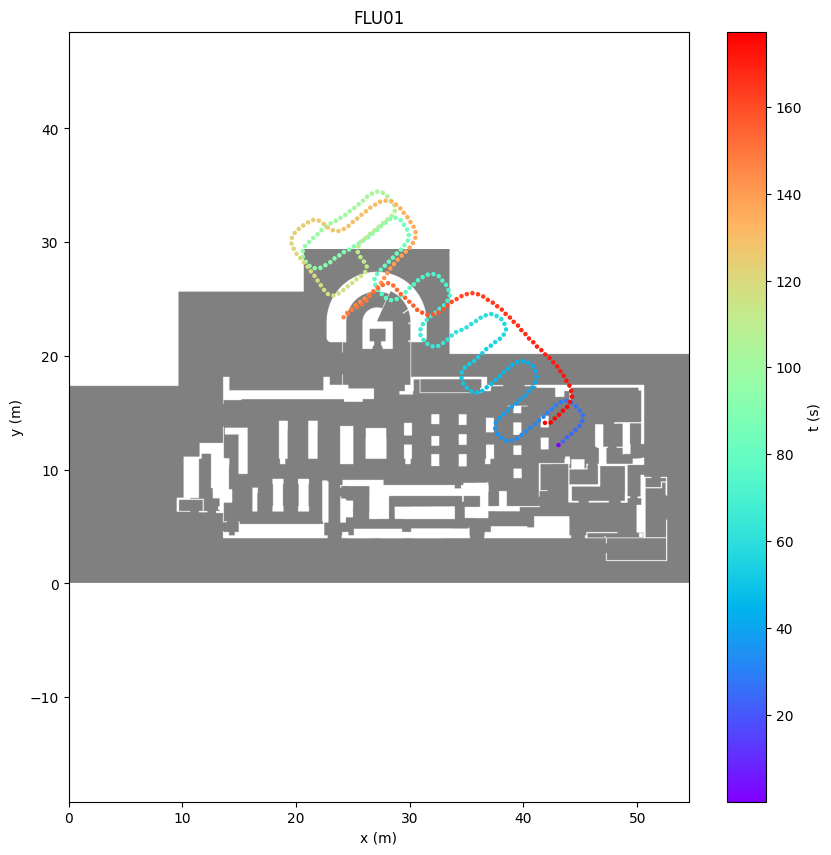

In [9]:
from sub import drift, utils

importlib.reload(drift)
importlib.reload(utils)


first_time_remove_drift_angle, first_time_remove_drift_angle_displacement = (
    drift.remove_drift_in_angle_df(
        acc_df,
        rotate_by_first_half_angle,
        ground_truth_df,
    )
)


# マップの描画
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    first_time_remove_drift_angle_displacement,
    fig_size=(10, 10),
    display_map=True,
)

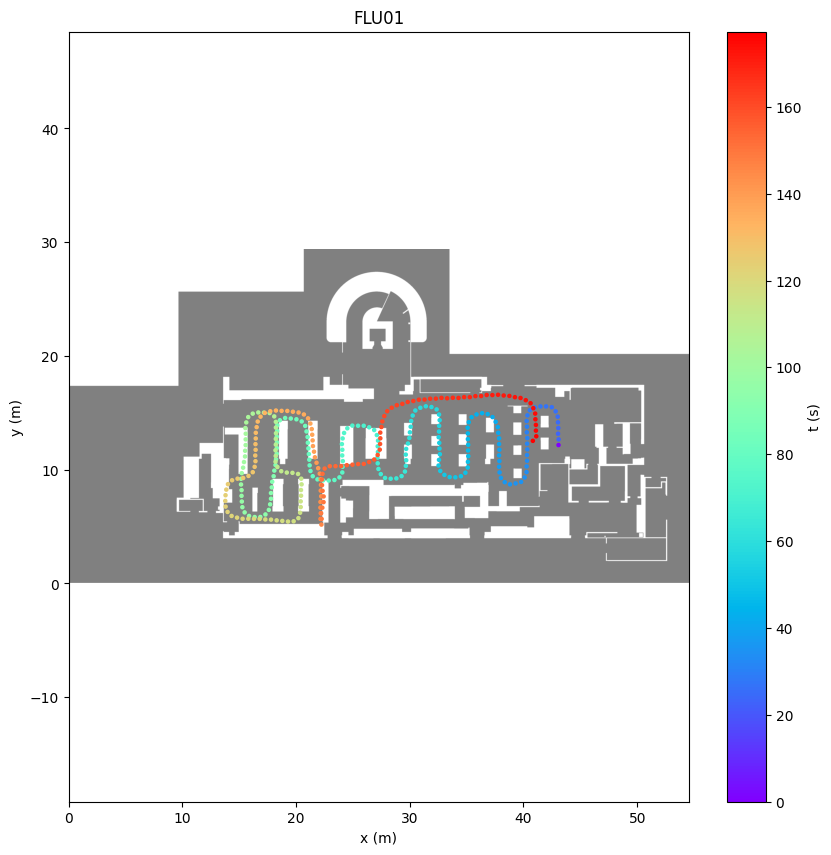

In [10]:
# refactored code

from sub import estimate, pdr_direction, utils

importlib.reload(pdr_direction)
importlib.reload(utils)
importlib.reload(estimate)

straight_angle_df, straight_angle_displacement = (
    pdr_direction.rotate_trajectory_to_optimal_alignment_using_map(
        acc_df,
        first_time_remove_drift_angle,
        edit_map_dict,
        floor_name,
        dx,
        dy,
        ground_truth_first_point={
            "x": ground_truth_df.x[0],
            "y": ground_truth_df.y[0],
        },
    )
)


utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
    fig_size=(10,10),
)

水平成分と垂直成分の色を変更するコード


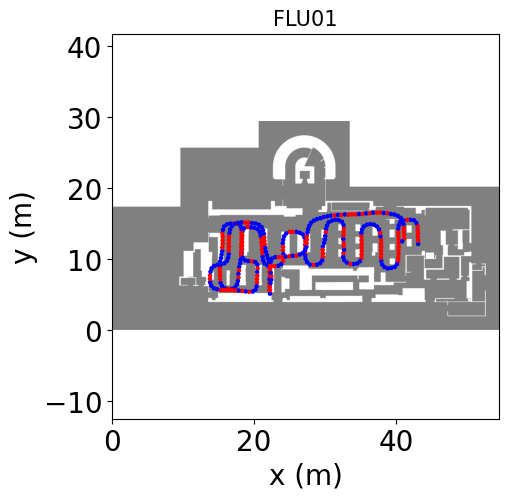

In [11]:
from sub import utils

importlib.reload(utils)

utils.plot_map(map_dict, floor_name, dx, dy, font_size=15, fig_size=(5, 5))

colors = straight_angle_displacement["is_vertical_or_horizontal"].map(
    {True: "r", False: "b", np.nan: "b"},
)

plt.scatter(
    straight_angle_displacement.x_displacement,
    straight_angle_displacement.y_displacement,
    c=colors,
    s=5,
)
plt.tick_params(labelsize=20)
plt.xlabel("x (m)", fontsize=20)
plt.ylabel("y (m)", fontsize=20)
plt.show()

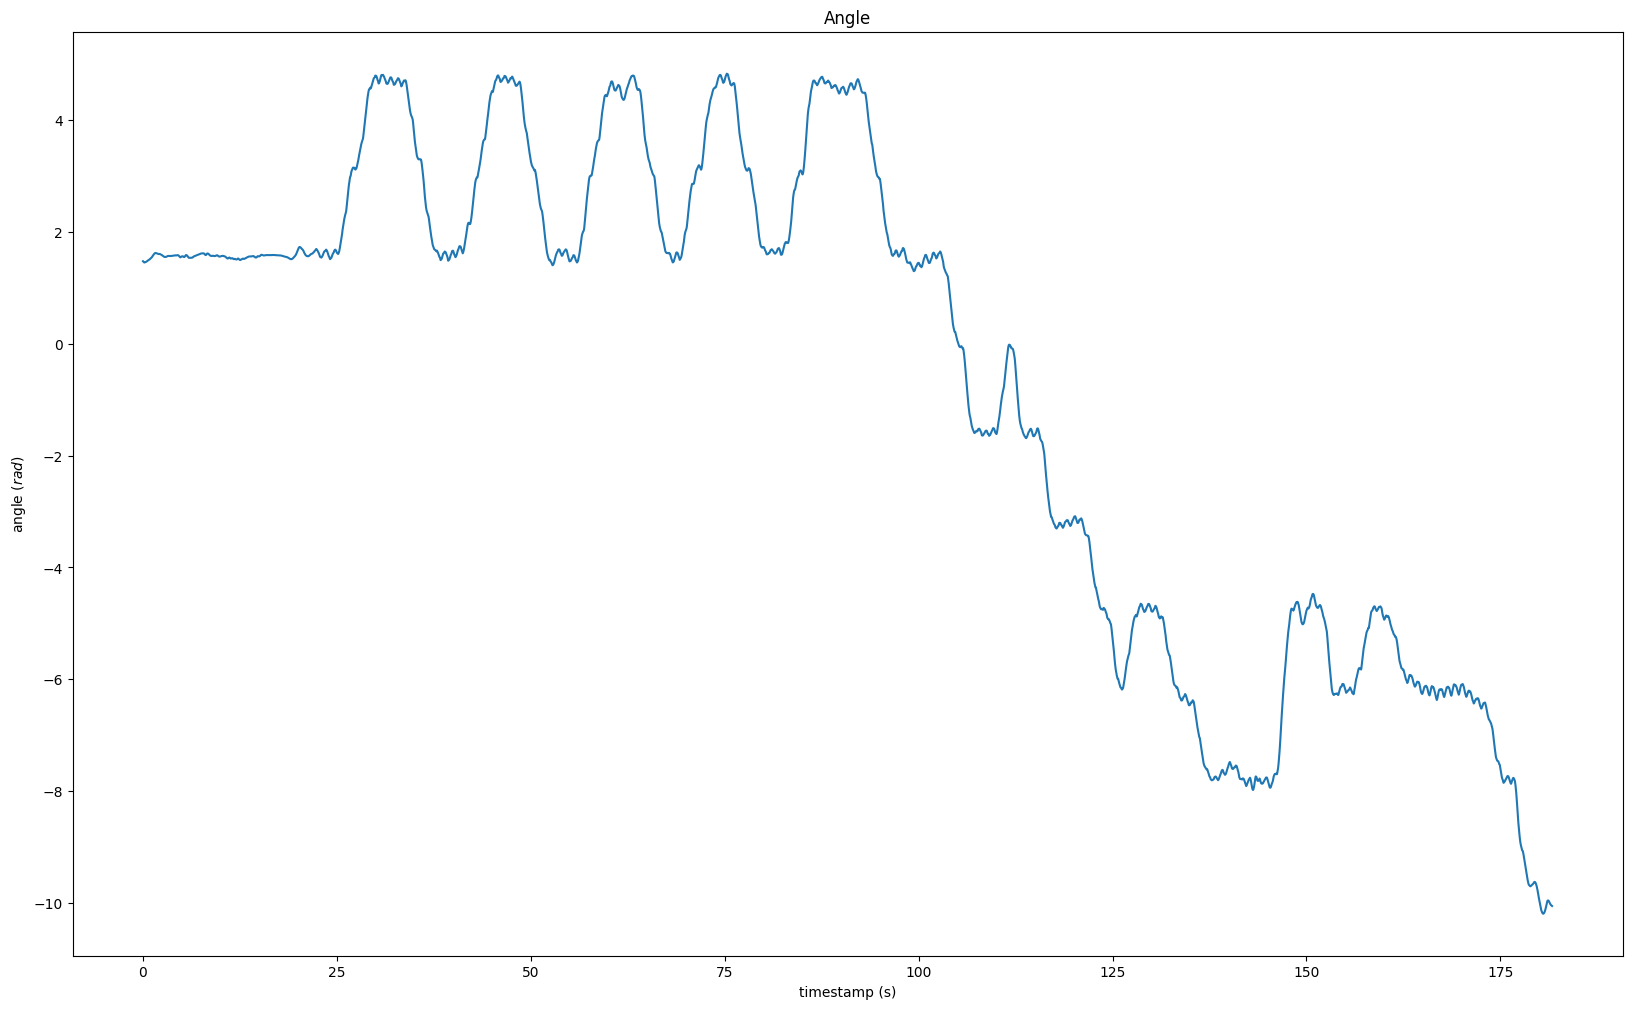

In [12]:
plt.plot(straight_angle_df.ts, straight_angle_df["x"])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

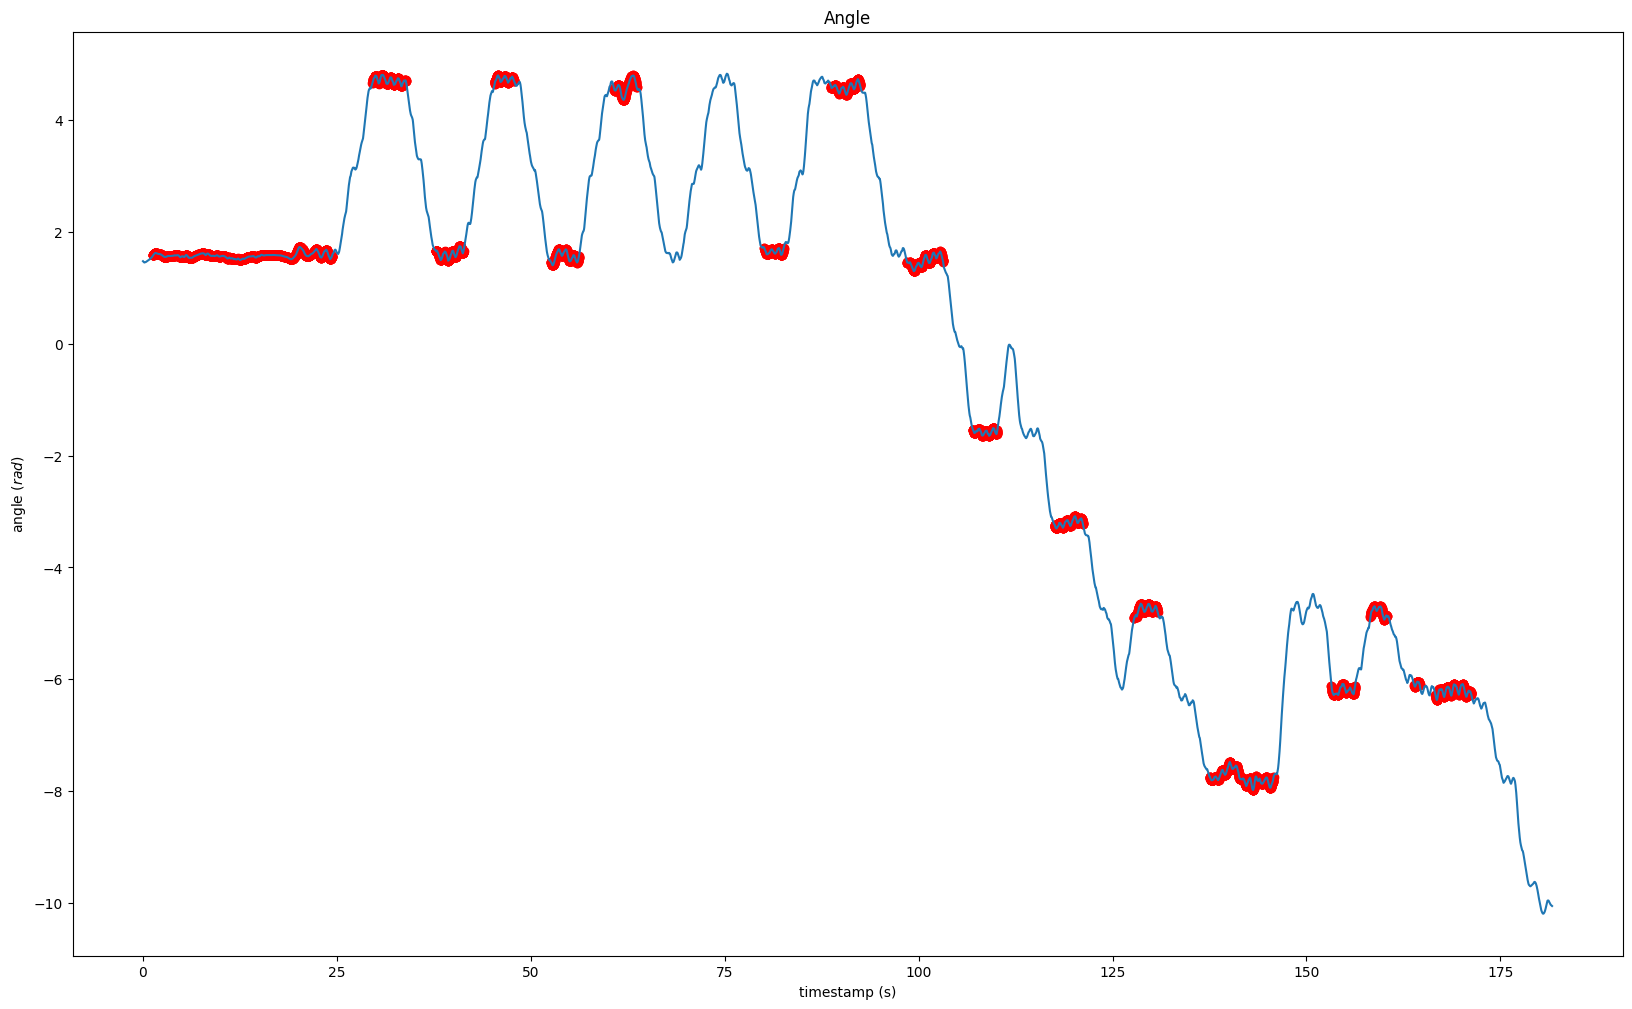

In [13]:
import pandas as pd
from sub import stable

# 安定歩行区間を設けて,その区間に入っている場合角度を補正する
# 安定歩行区間とは,角度が一定範囲内に数秒間収まっている区間のこと
# 角度範囲は+-20度とする,数秒間は5秒とする
stable_angle_df = stable.extract_stable_angle(straight_angle_df, 0.35, 3)

# plotする stable_flagがtrueのものは赤色で表示
plt.plot(stable_angle_df.ts, stable_angle_df["x"])
plt.scatter(
    stable_angle_df["ts"][stable_angle_df["stable_flag"]],
    stable_angle_df["x"][stable_angle_df["stable_flag"]],
    c="r",
)
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

Text(0, 0.5, 'angle ($rad$)')

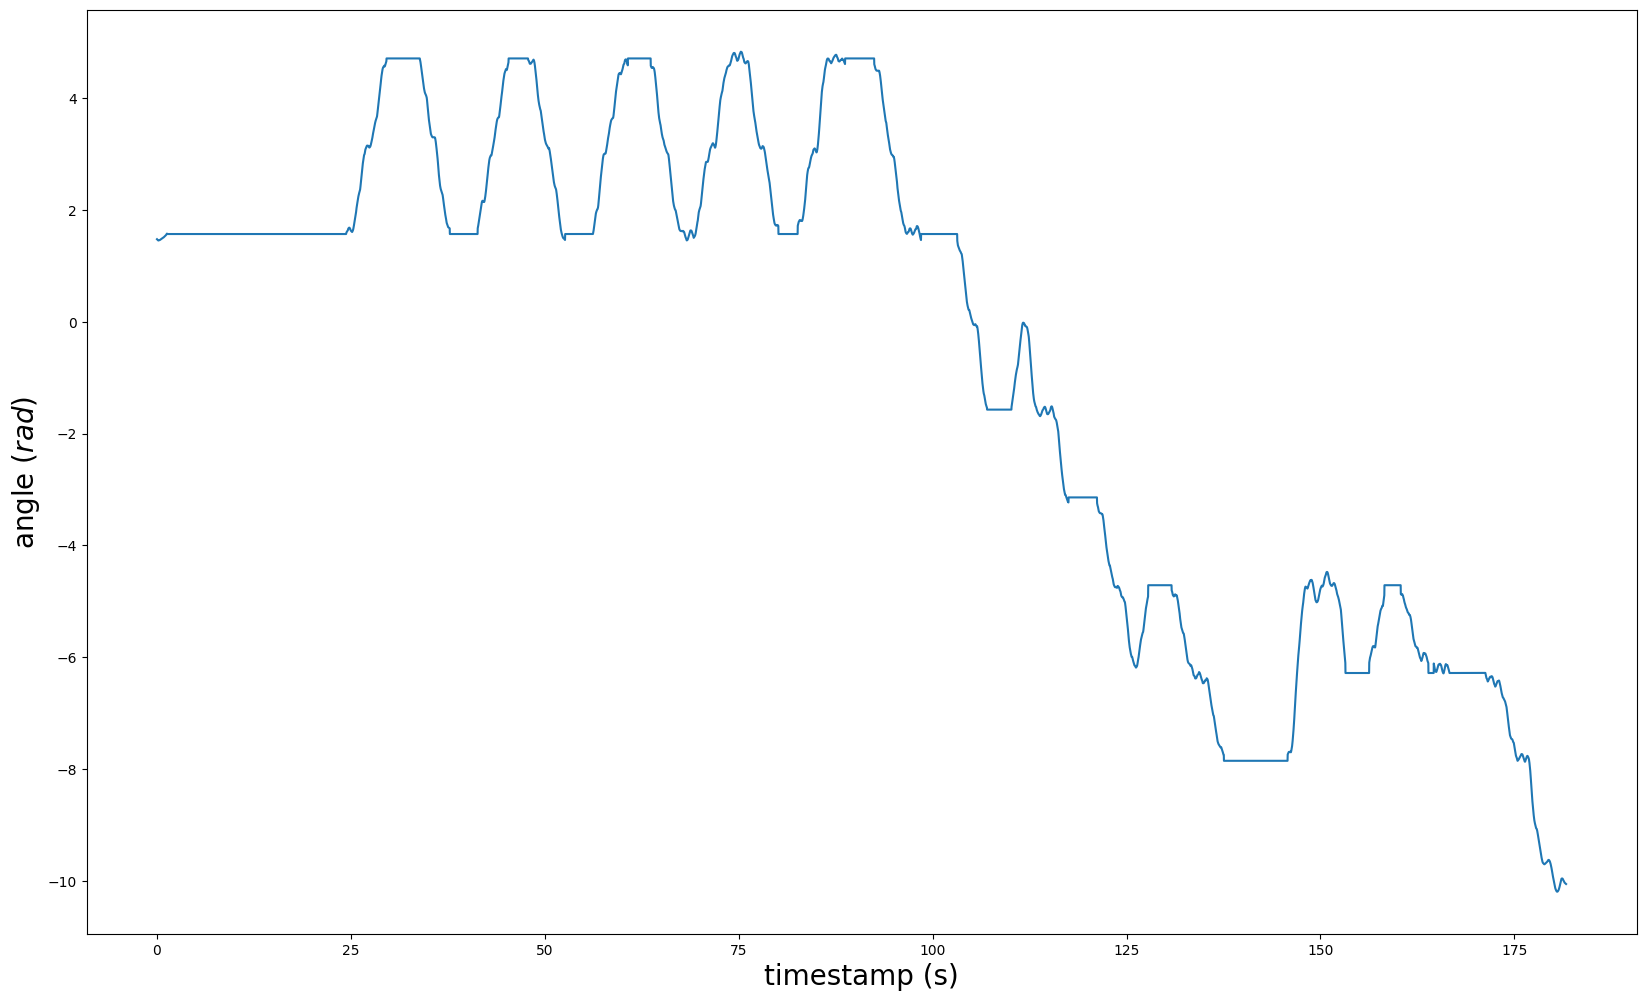

In [14]:
from sub import stable

correct_stable_angle_df = stable.correct_angle(stable_angle_df, "x")

plt.plot(correct_stable_angle_df.ts, correct_stable_angle_df["x"])
plt.xlabel("timestamp (s)", fontsize=20)
plt.ylabel("angle ($rad$)", fontsize=20)
# plt.show()

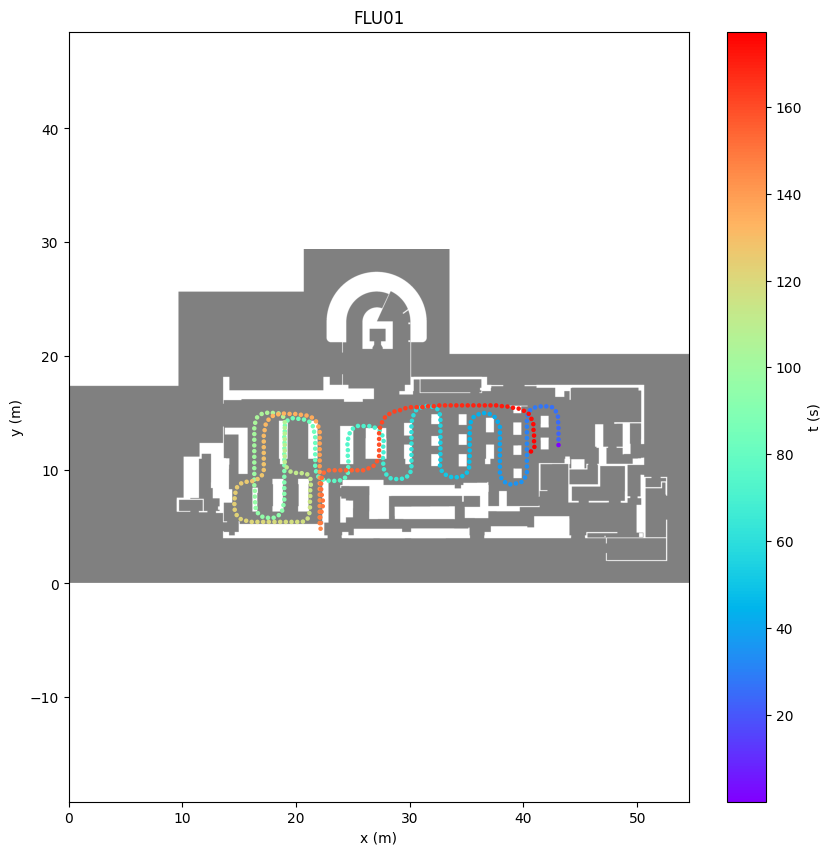

In [15]:
from sub import estimate, utils

importlib.reload(estimate)
importlib.reload(utils)


correct_stable_angle_df_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        correct_stable_angle_df,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["ts"][0],
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    correct_stable_angle_df_displacement,
    fig_size=(10, 10),
)

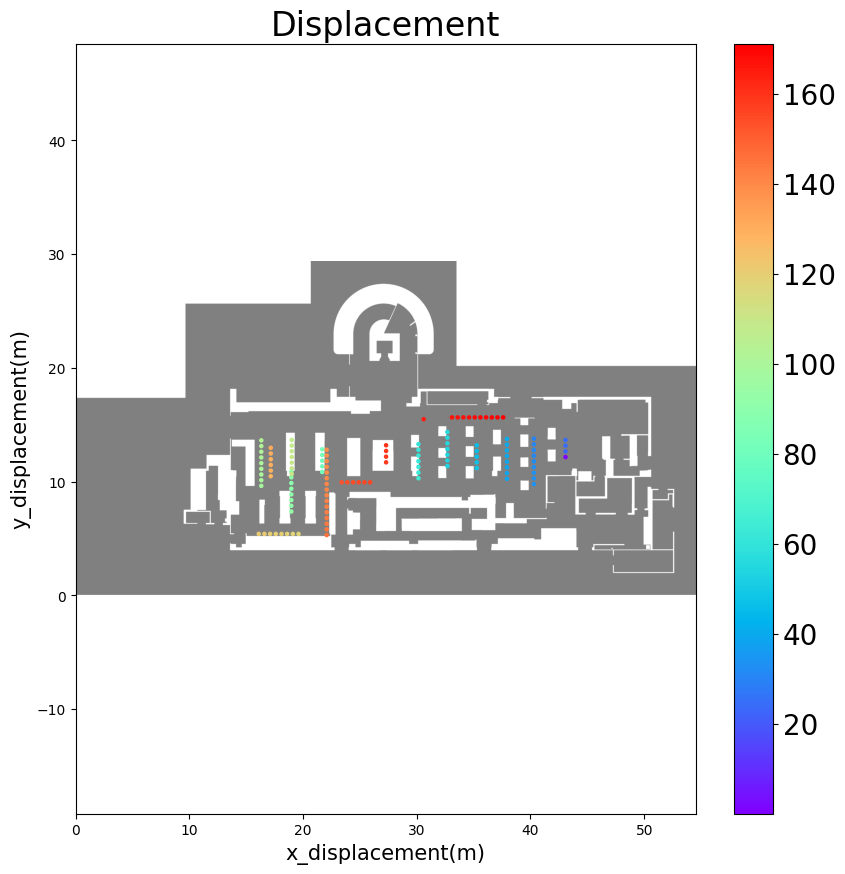

In [16]:
from sub import estimate, stable, utils

importlib.reload(estimate)
importlib.reload(utils)
importlib.reload(stable)

correct_stable_angle_df_displacement = (
    stable.convert_to_peek_angle_and_compute_displacement_by_angle(
        correct_stable_angle_df,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["ts"][0],
    )
)

# stable_flagがtrueのもののみを描く
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        correct_stable_angle_df_displacement.x_displacement[
            correct_stable_angle_df_displacement["stable_flag"]
        ],
        correct_stable_angle_df_displacement.y_displacement[
            correct_stable_angle_df_displacement["stable_flag"]
        ],
        c=correct_stable_angle_df_displacement.ts[
            correct_stable_angle_df_displacement["stable_flag"]
        ],
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

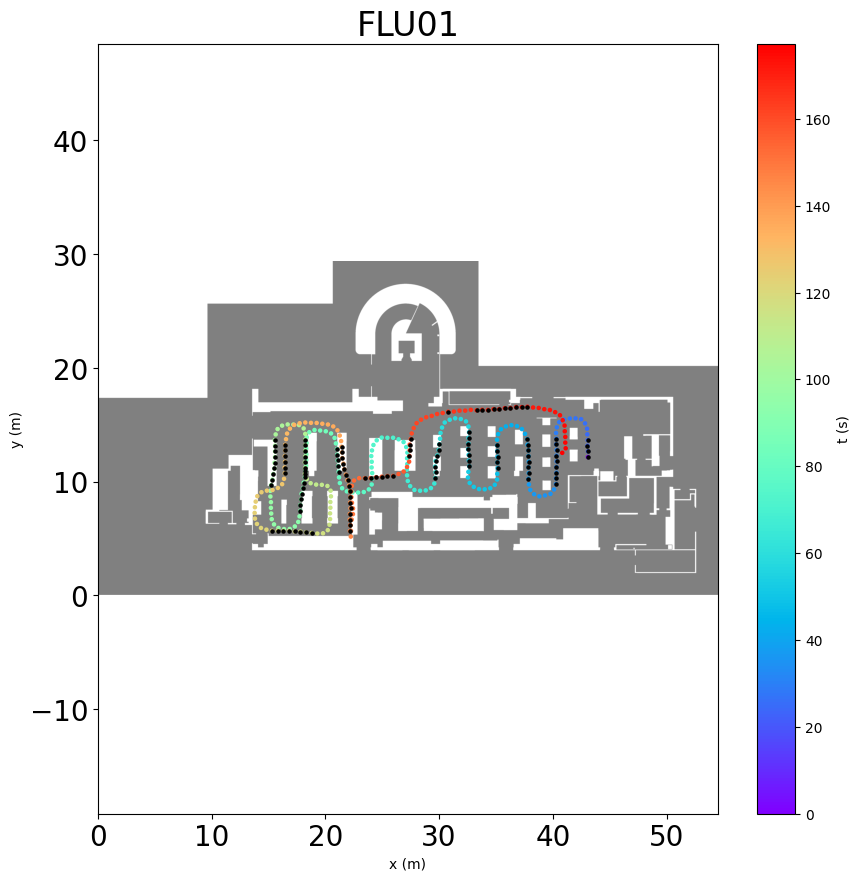

In [17]:
import pandas as pd
from sub import stable, utils

importlib.reload(stable)
importlib.reload(utils)


# straight_angle_displacementにcorrect_angle_df_displacementのstable_flagを追加
straight_angle_displacement["stable_flag"] = correct_stable_angle_df_displacement[
    "stable_flag"
]


stable.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
    fig_size=(10, 10),
    straight_angle_displacement=straight_angle_displacement,
)

# ax = utils.plot_displacement_map_test(
#     map_dict,
#     floor_name,
#     dx,
#     dy,
#     straight_angle_displacement,
#     fig_size=(10, 10),
# )
# plt.scatter(
#     straight_angle_displacement.x_displacement[
#         straight_angle_displacement["stable_flag"]
#     ],
#     straight_angle_displacement.y_displacement[
#         straight_angle_displacement["stable_flag"]
#     ],
#     c="k",
#     s=5,
# )

0    1
1    2
2    3
3    4
Name: x, dtype: int64
0    1
1    2
2    3
3    4
Name: x, dtype: int64


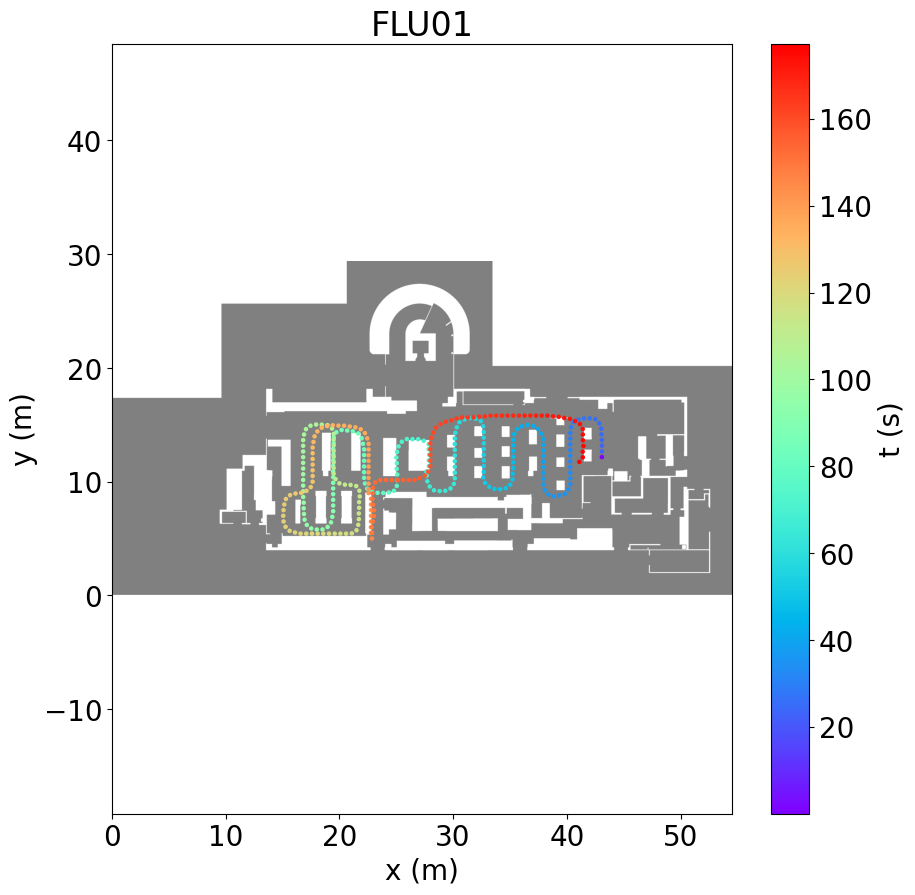

In [18]:
from sub import estimate, map_matching, stable, utils

importlib.reload(estimate)
importlib.reload(map_matching)
importlib.reload(stable)
importlib.reload(utils)

# correct_unpassable_displacement = map_matching.move_unwalkable_points_to_walkable(
#     acc_df,
#     straight_angle_df,
#     map_dict,
#     floor_name,
#     dx,
#     dy,
#     ground_truth_first_point={
#         "x": ground_truth_df.x[0],
#         "y": ground_truth_df.y[0],
#     },
# )

correct_unpassable_displacement = estimate.move_unwalkable_points_to_walkable(
    correct_stable_angle_df_displacement,
    map_dict,
    floor_name,
    dx,
    dy,
)


utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    correct_unpassable_displacement,
    fig_size=(10, 10),
    font_size=20,
    label_size=20,
)

In [19]:
output_df = pd.DataFrame(
    {
        "timestamp": correct_unpassable_displacement["ts"],
        "x": correct_unpassable_displacement["x_displacement"],
        "y": correct_unpassable_displacement["y_displacement"],
        "floor": floor_name,
    },
)

# output_df.to_csv("8_1_pdr_est.csv", index=False, header=False)